Enter the cryptocurrency symbol (e.g., BTC-USD): ^NSEI
Enter the start date2016-05-20
Enter the end date2025-05-29


[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0311 - val_loss: 6.5818e-04
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.7117e-04 - val_loss: 8.3096e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 3.8387e-04 - val_loss: 5.4580e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 3.8260e-04 - val_loss: 8.5197e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 3.4165e-04 - val_loss: 0.0011
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 2.8031e-04 - val_loss: 6.2289e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 3.2264e-04 - val_loss: 5.1479e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.1911e-04 - val_loss: 4.4864e-04
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 2.8912e-04 - val_loss: 0.0016
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 3.1752e-04 - val_loss: 0.0013
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 2.7807e-04 - val_loss: 5.6535e-04
Ep

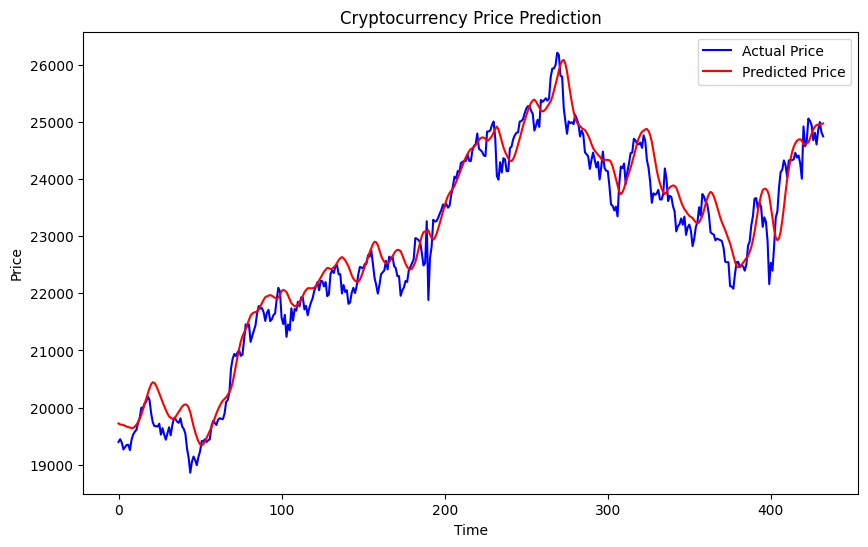

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted next-day ^NSEI price: $24967.50


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def load_data(symbol, start, end):
    df = yf.download(symbol, start=start, end=end)
    df = df[['Close']]
    return df


def preprocess_data(data, window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # 3D input for LSTM
    return X, y, scaler


def build_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def predict_future(model, data, scaler, window_size=60):
    last_60_days = data[-window_size:].values
    last_60_scaled = scaler.transform(last_60_days)
    X_test = np.reshape(last_60_scaled, (1, window_size, 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    return pred_price[0][0]


def plot_predictions(actual, predicted):
    plt.figure(figsize=(10,6))
    plt.plot(actual, color='blue', label='Actual Price')
    plt.plot(predicted, color='red', label='Predicted Price')
    plt.title('Cryptocurrency Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

symbol = input("Enter the cryptocurrency symbol (e.g., BTC-USD): ")
start=input("Enter the start date")
end=input("Enter the end date")
df = load_data(symbol,start,end)
X, y, scaler = preprocess_data(df)


split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


model = build_model()
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


plot_predictions(actual_prices, predicted_prices)


future_price = predict_future(model, df[['Close']], scaler)
print(f"Predicted next-day {symbol} price: {future_price:.2f}")